<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/cointegrationReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm

from scipy.special import logit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
warnings.filterwarnings('ignore') #Disable warning

In [ ]:
# Import dependence variable
odr = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv'
)

# Select segment, drop columns
odr = odr.query(
    "Segment == 'CU'"
).drop(
    ['Segment', 'Monthkey'],
    axis = 1
).eval(
    "ODR = Bad / N"
)

# Transform to logit
y = logit(odr['ODR'])
y[:5]

0   -3.236680
1   -3.162347
2   -3.127475
3   -3.093313
4   -3.061565
Name: ODR, dtype: float64

In [ ]:
# Import macroeconomics data
mev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv'
)

# Select variables for linear regression model
selectedVars = ['GDP_C_lg12', 'MPI_C_lg12']
X = sm.add_constant(mev[selectedVars]) #Add intercept
X.head(5)

,const,GDP_C_lg12,MPI_C_lg12
0,1.0,0.125214,0.239164
1,1.0,0.086355,0.119307
2,1.0,0.052505,0.143477
3,1.0,0.032748,0.089870
4,1.0,0.026525,0.046398


In [ ]:
# Linear regression model
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.68
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           6.99e-15
Time:                        09:13:01   Log-Likelihood:                 100.82
No. Observations:                  59   AIC:                            -195.6
Df Residuals:                      56   BIC:                            -189.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9473      0.019   -155.761      0.0

In [ ]:
# Define better plot function
def plotSeasonal(result, axs):
  result.observed.plot(ax = axs[0], legend = False)
  axs[0].set_ylabel('Observed')
  axs[0].yaxis.set_major_formatter(
        mtick.FormatStrFormatter('%.2f')
  )
  result.trend.plot(ax = axs[1], legend = False)
  axs[1].set_ylabel('Trend')
  axs[1].yaxis.set_major_formatter(
      mtick.FormatStrFormatter('%.2f')
  )
  result.seasonal.plot(ax = axs[2], legend = False)
  axs[2].set_ylabel('Seasonal')
  axs[2].yaxis.set_major_formatter(
    mtick.FormatStrFormatter('%.2f')
  )
  result.resid.plot(ax = axs[3], legend = False)
  axs[3].set_ylabel('Residual')
  axs[3].yaxis.set_major_formatter(
      mtick.FormatStrFormatter('%.2f')
  )
  return

In [ ]:
# Create regression DataFrame
dfReg = pd.concat(
    [
     y.rename('logitODR'),
     X.iloc[:, 1:],
     result.resid.rename('Residual')
    ],
    axis = 1
).set_index(pd.to_datetime(mev['Date']))
dfReg.head(5)

,logitODR,GDP_C_lg12,MPI_C_lg12,Residual
Date,,,,
2014-01-01,-3.236680,0.125214,0.239164,0.075215
2014-02-01,-3.162347,0.086355,0.119307,0.012898
2014-03-01,-3.127475,0.052505,0.143477,-0.005045
2014-04-01,-3.093313,0.032748,0.089870,-0.036584
2014-05-01,-3.061565,0.026525,0.046398,-0.039223


## Cointegration function
Macroeconomic time series studies are based on the assumption that the underlying time series is stationary. Time series studies, however, show that many time series are not stationary in their levels but stationary in differences. The results of regression a nonstationary time series variable on another nonstationary time series variable yields often spurious results although there is no meaningful relationship between them.

### Engle–Granger two-step method
Engle-Granger methodology follows two-step estimations. The first step generates the residuals and the second step employs generated residuals to estimate a regression of firstdifferenced residuals on lagged residuals. Hence, any possible error from the first step will be carried into second step.

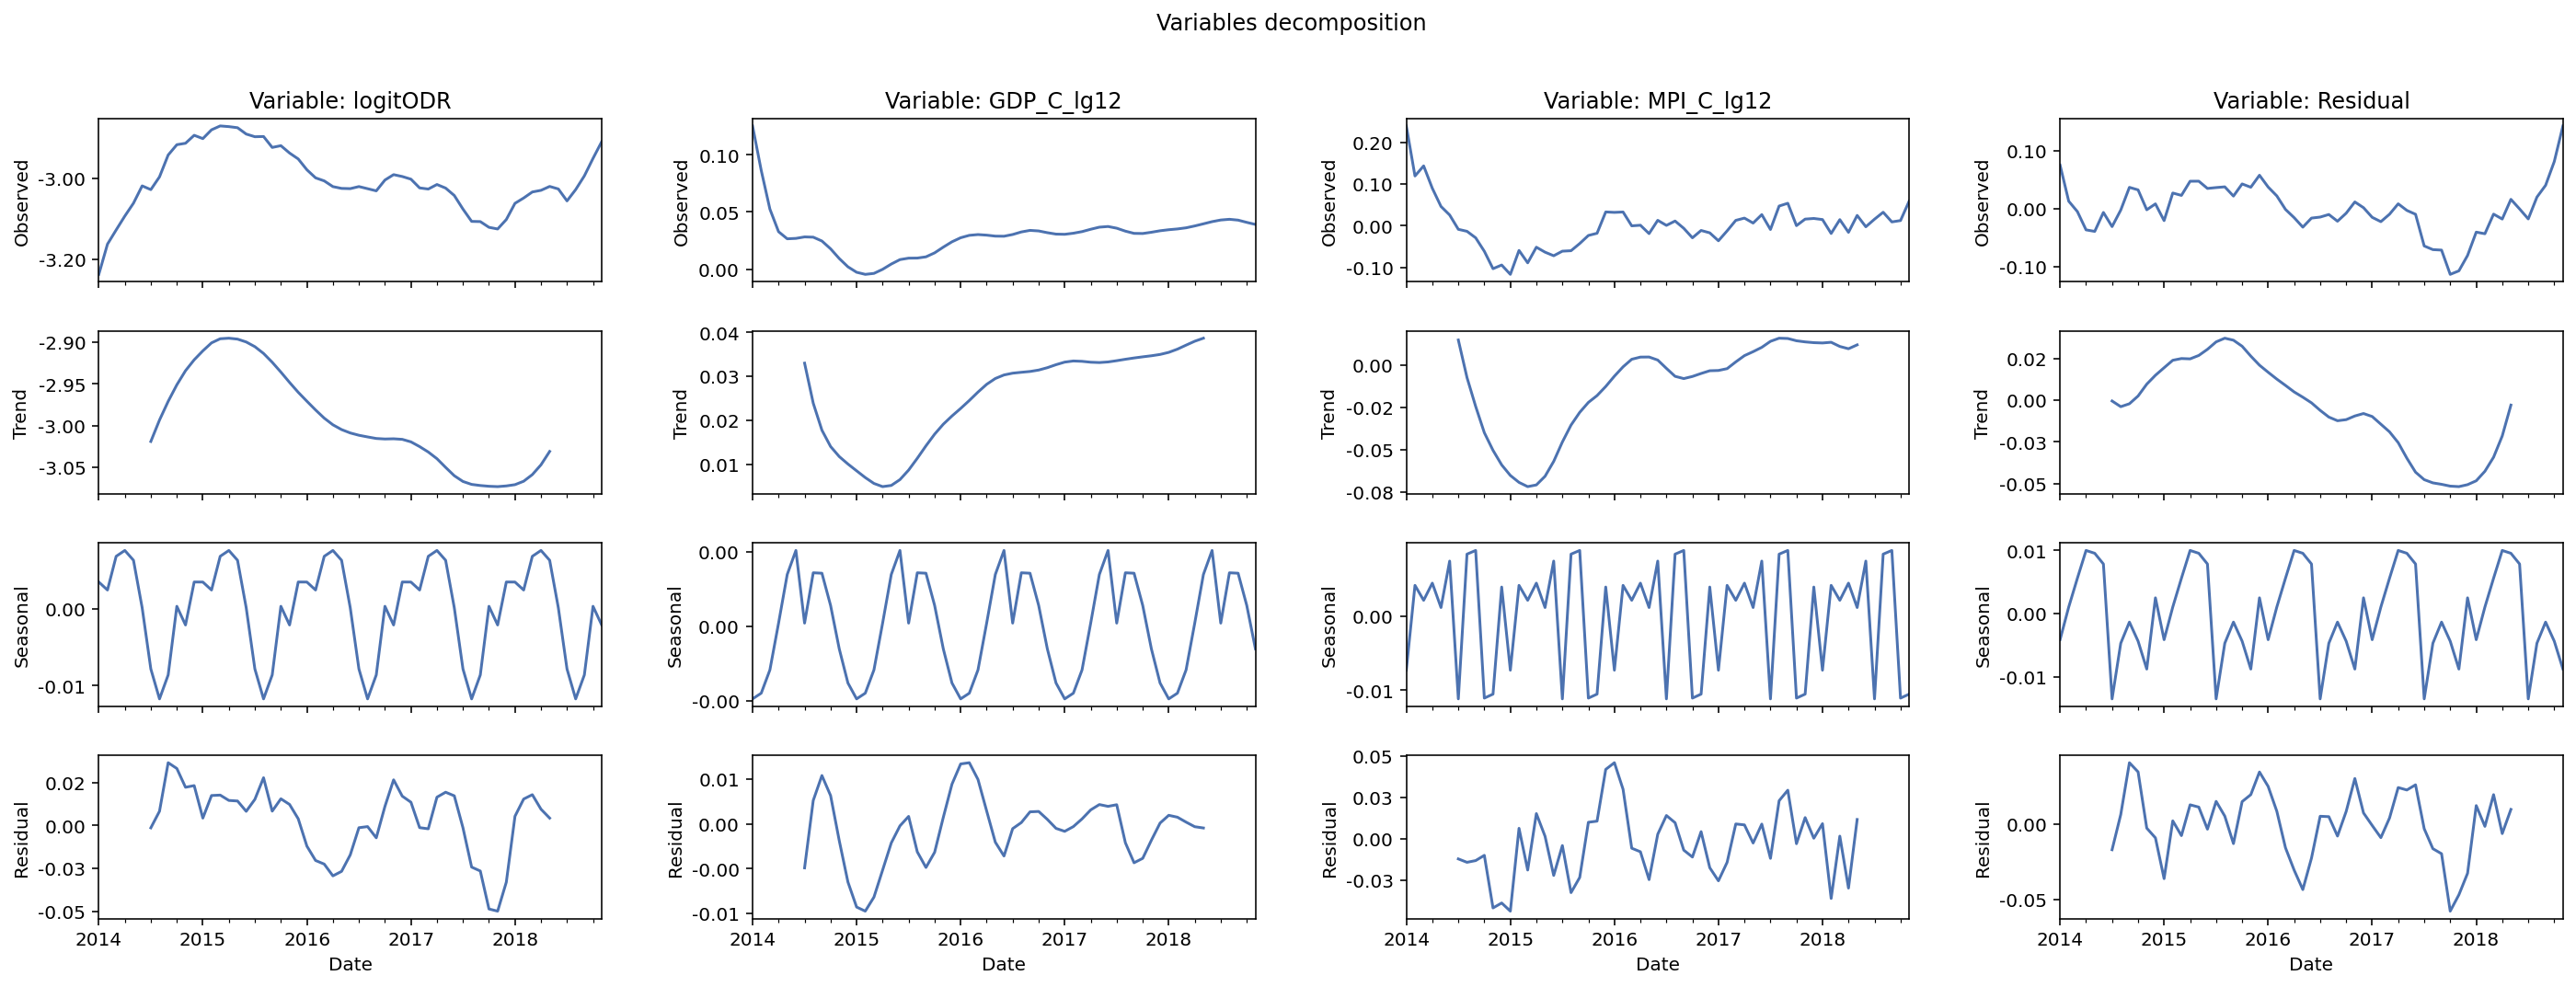

In [ ]:
# Time series decomposition
factorList = ['logitODR', 'GDP_C_lg12', 'MPI_C_lg12', 'Residual']
fig, axs = plt.subplots(
    4, len(factorList),
    figsize = (24, 8), sharex = True
)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle('Variables decomposition')
for i, factor in enumerate(factorList):
  results = seasonal_decompose(
      dfReg[factor],
      model = 'additive'
  )
  axs[0, i].set_title(f'Variable: {factor}')
  plotSeasonal(results, axs[:, i])
plt.show()

### Interpretation 
The following cases are taken into account to conclude the stationarity analysis of regression model:
 - If there is only one from either independent variables or dependence variable is stationary, the model is mis-specified
 - If both of independent variables and dependence variables are non-stationary and the model residual is also non-stationary, the model concluded to be mis-specified
 - If both of independent variables and dependence variables are non-stationary **but the model residual is stationary**, the model is cointegrated
 - If both of the independent variables and dependence variable are stationary, then the model is correctly specified **without cointegrated needed**

In [ ]:
# Cointegrated function --> Unit-root test (ADF)
ADFResults = []

for var in dfReg.columns:
  adf, pVal, _, _, criticalValues, _ = adfuller(
      dfReg[var],
      regression = 'nc',
      autolag = 'AIC'
  )
  if adf <= criticalValues['5%']:
    result = 'Stationary'
  else:
    result = 'Unit root'
  ADFResults.append([var, adf, pVal, result])

# To DataFrame
ADFResults = pd.DataFrame(ADFResults, columns = ['Variable', 'ADFStat', 'PValue', 'Result'])
ADFResults

,Variable,ADFStat,PValue,Result
0,logitODR,-0.750549,0.391313,Unit root
1,GDP_C_lg12,0.204392,0.748023,Unit root
2,MPI_C_lg12,-2.951064,0.003115,Stationary
3,Residual,-1.587263,0.105934,Unit root
